In [1]:
import os
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib
from src import render_model_gym

from src import helpers
from src.definitions import PROJECT_ROOT, enforce_absolute_path

import src.lucy_classes_v1 as lucy

importlib.reload(lucy)

<module 'src.lucy_classes_v1' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v1.py'>

In [2]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/lucy_v2.xml")


def new_vec_env(env: lucy.LucyEnv, monitor_dir: str):
    return make_vec_env(
        env,
        n_envs=n_envs,
        vec_env_cls=SubprocVecEnv,
        monitor_dir=monitor_dir,
    )


print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(
    f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators"
)
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/lucy_v1_standing_{sim_start_time}/"
os.makedirs(log_dir, exist_ok=True)
print(f"Standing log directory: {log_dir}")

MuJoCo version: 3.4.0
Lucy model loaded: 53 qpos dims, 44 qvel dims, 38 actuators
Observation space will be: 95 dims (qpos[2:] + qvel)
Standing log directory: logs/lucy_v1_standing_2026-01-10_17-48/


Episode terminated during frame collection.


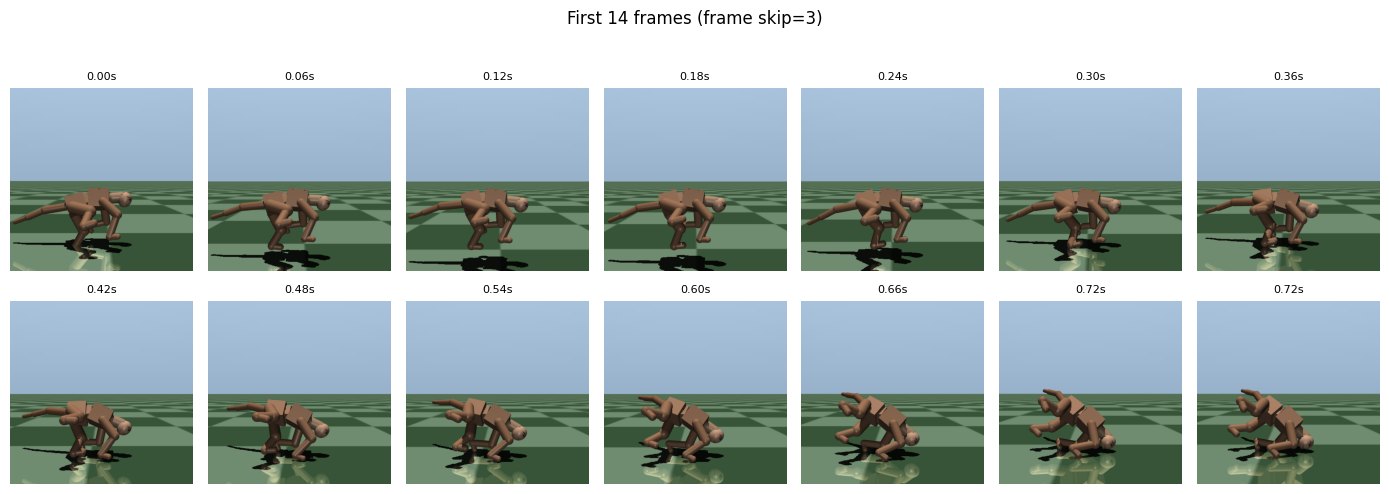

,time,chest_height,forward_velocity,total_height_reward,head_direction_reward,leg_pos_reward,straight_tail_reward,reward,cum_reward
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.06,0.253429,0.209604,1.500000e+00,0.0,0.474480,-0.176747,3.257176,6.141403
2,0.12,0.282935,0.169889,1.500000e+00,0.0,0.468291,-0.097313,3.394390,16.297748
3,0.18,0.279605,0.145654,1.500000e+00,0.0,0.455363,-0.054485,3.434020,26.656200
4,0.24,0.241025,0.163971,1.500000e+00,0.0,0.446434,-0.144747,3.270672,36.579886
5,0.30,0.193766,0.288830,4.044437e-12,0.0,0.434562,0.012062,-0.106511,39.124560
6,0.36,0.179196,0.302560,6.248566e-18,0.0,0.409722,-0.034873,-0.223343,38.516380
7,0.42,0.168814,0.348226,8.082758e-18,0.0,0.393578,-0.150997,1.610292,43.602555
8,0.48,0.162704,0.229153,7.382719e-17,0.0,0.384307,-0.134071,1.614049,48.474588
9,0.54,0.158487,0.142549,1.271457e-15,0.0,0.379439,-0.095099,1.609806,53.393798


In [3]:
importlib.reload(lucy)


def make_env(render_mode="None", *args, **kwargs):
    return lucy.LucyStandingWrapper(
        lucy.LucyEnv(
            xml_file=xml_path, render_mode=render_mode, max_episode_seconds=10
        ),
    )

standing_attrs = [
    "chest_height",
    "forward_velocity",
    "total_height_reward",
    "head_direction_reward",
    "leg_pos_reward",
    "straight_tail_reward",
]

env = make_env(render_mode="rgb_array")

df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=standing_attrs,
)
plt.show()
df

In [ ]:
standing_vec_env = new_vec_env(make_env, log_dir)


standing_vec_env = VecMonitor(standing_vec_env, log_dir)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {log_dir}")


standing_model = PPO(
    "MlpPolicy",
    standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=3,
    gamma=0.99,
    gae_lambda=0.9,
    clip_range=0.2,
    ent_coef=0.05,
    learning_rate=3e-4,
    target_kl=0.05,
    policy_kwargs=dict(
        net_arch=dict(
            pi=[512, 512, 512, 256], vf=[512, 512, 512, 256]
        )  # Larger network
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 10_000_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Created 7 parallel standing environments
Logging to: logs/lucy_v1_standing_2026-01-10_17-48/
Using cpu device
Training standing policy for 10,000,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 53.6     |
|    ep_rew_mean     | -49.9    |
| time/              |          |
|    fps             | 3198     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 14336    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 54.1       |
|    ep_rew_mean          | -42.4      |
| time/                   |            |
|    fps                  | 2675       |
|    iterations           | 2          |
|    time_elapsed         | 10         |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.01954825 |
|    clip_fraction        | 0.284      |
|    

In [ ]:
standing_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v2_standing_model_{sim_start_time}"
)
standing_model.save(standing_model_path)
print(f"Standing model saved to: {standing_model_path}")

Standing model saved to: C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-10_17-42


In [ ]:
importlib.reload(render_model_gym)
#render_model_gym.render_model_gym(standing_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0250s per step
Running simulation at 1.0x speed... Close the window to exit.


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)



Stopped by user


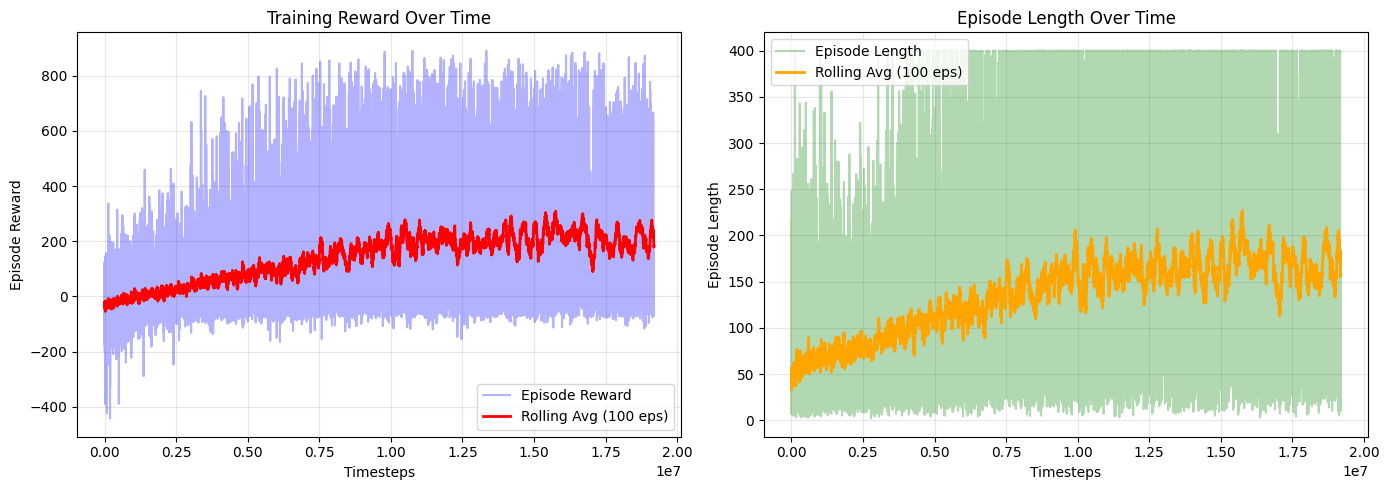

Training Summary:
Total episodes: 39070
Final avg reward (last 100 eps): 180.66
Max reward: 890.56
  Final avg length (last 100 eps): 157.6


In [ ]:
standing_df = load_results(log_dir)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

# Walking training

<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
C:\Users\326po\AppData\Local\Temp\ipykernel_31536\1928161085.py:6: SyntaxWarning: invalid escape sequence '\G'
  "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


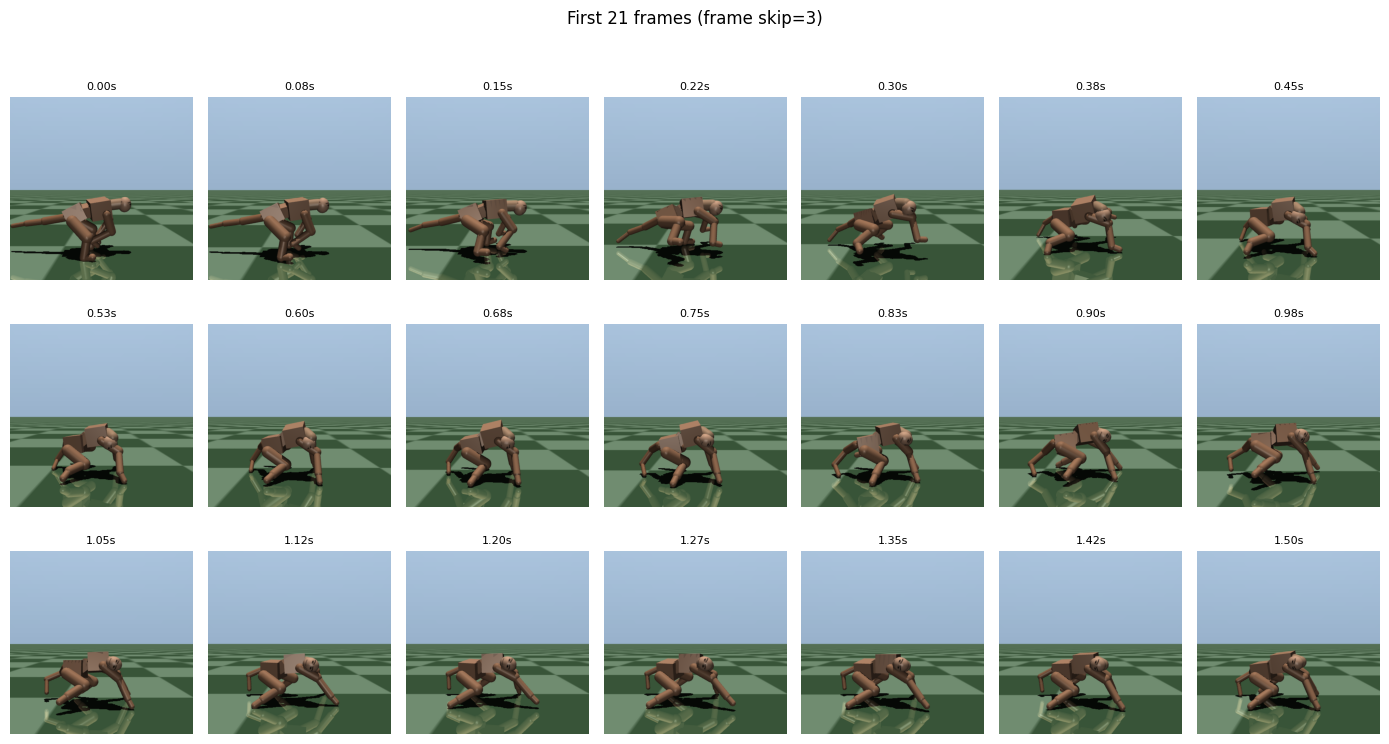

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.203094,-0.000304,-0.030994,0.0,-0.123776,0.065888,0.574494,1.298732
2,0.150,0.191743,-0.021690,-0.016557,0.0,-0.013970,0.065698,0.608537,3.013690
3,0.225,0.193660,0.009523,0.106428,0.0,-0.000455,0.061216,0.717809,4.933953
4,0.300,0.204553,0.173989,0.263083,0.0,-0.004376,0.052953,1.459507,8.909913
5,0.375,0.167353,0.359036,0.247660,0.0,-0.000313,0.047965,1.141221,11.921501
6,0.450,0.177823,0.105828,0.045086,0.0,-0.109223,0.042695,0.959809,15.010016
7,0.525,0.176959,0.165111,0.060898,0.0,-0.072806,0.038036,0.349232,17.395844
8,0.600,0.187789,0.103013,0.120719,0.0,-0.117010,0.035528,0.689056,19.575130
9,0.675,0.198001,-0.080238,0.035652,0.0,-0.111726,0.037419,1.180396,21.932807


In [ ]:
# Create walking training environment
importlib.reload(lucy)

if "standing_model_path" not in locals():
    standing_model_path = (
        "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"
    )

walking_attrKeys = [
    "chest_height",
    "forward_velocity",
    "forward_reward",
    "gait_reward",
    "stillness_reward",
    "leg_pos_reward",
]


walking_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
walking_log_dir = f"logs/lucy_walking_{walking_start_time}/"
os.makedirs(walking_log_dir, exist_ok=True)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=30,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        forward_weight=1.0,
        gait_weight=0.2,
        body_contact_penalty=-2.0,
        standing_reward_discount_factor=0.3,
    )
    return env


env = make_walking_env(render_mode="rgb_array")
model = PPO.load(standing_model_path, env=env)

# attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=walking_attrKeys,
    model=model,
)
plt.show()
df

In [ ]:
walking_vec_env = new_vec_env(make_walking_env, walking_log_dir)
print(f"Loading from standing model at: {standing_model_path}")


walking_model = PPO.load(standing_model_path, env=walking_vec_env)
walking_model.set_env(walking_vec_env)

walking_model.learn(total_timesteps=20_000_000)

Loading from standing model at: C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-10_17-03
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 191      |
|    ep_rew_mean     | 148      |
| time/              |          |
|    fps             | 1875     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 184         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 1780        |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.012666949 |
|    clip_fraction        | 0.0798      |
|    clip_range           | 0.2         |
|  

KeyboardInterrupt: 

In [ ]:
walking_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v1_walking_model_{walking_start_time}"
)
walking_model.save(walking_model_path)

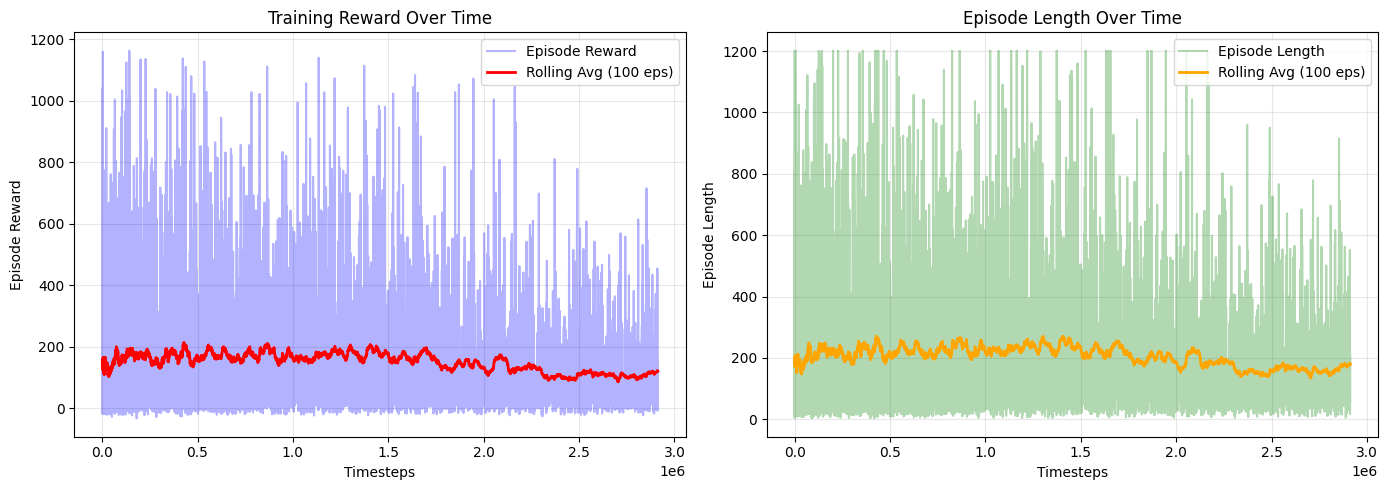

Training Summary:
Total episodes: 6450
Final avg reward (last 100 eps): 120.68
Max reward: 1163.06
  Final avg length (last 100 eps): 179.2


In [ ]:
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


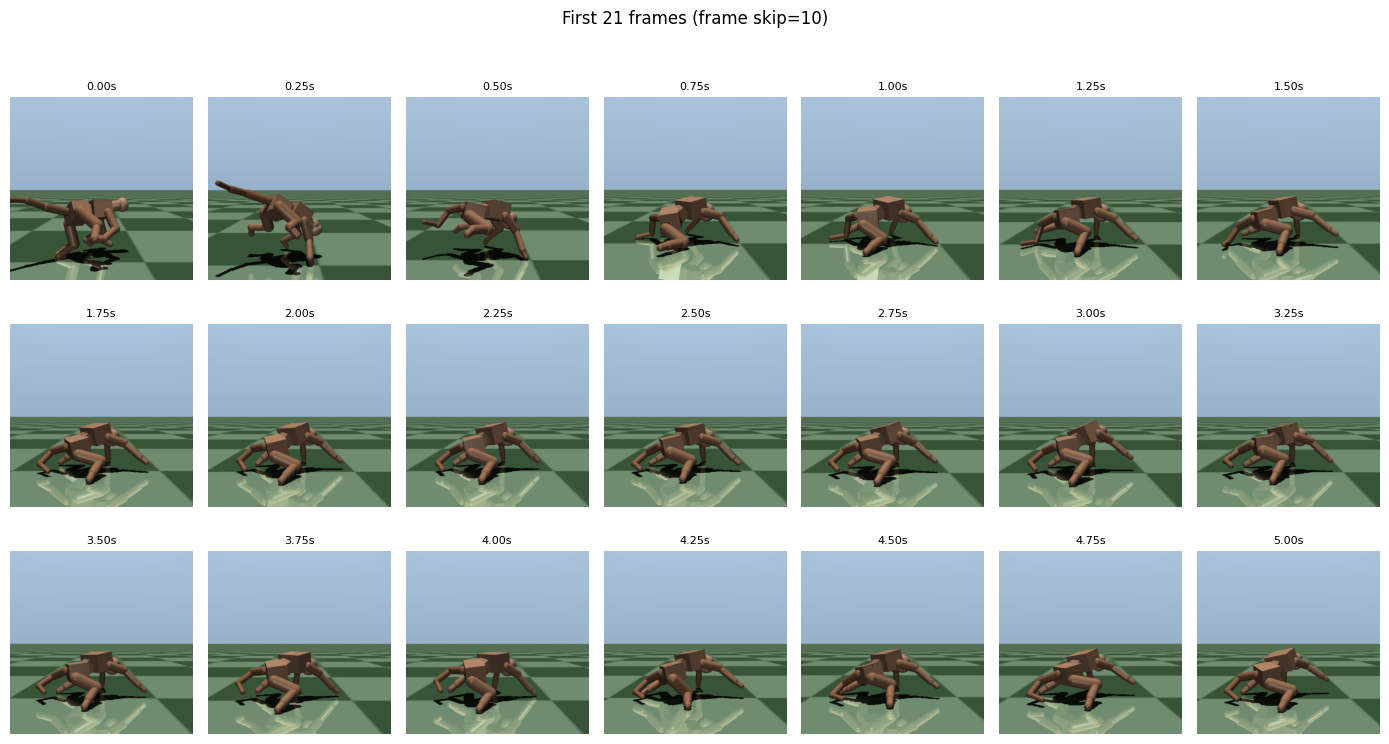

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,reward,cum_reward
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.25,0.196524,0.262187,-0.114874,0.0,-0.035012,0.052325,1.211152,16.574221
2,0.50,0.200569,-0.572662,-0.674486,0.0,-0.004532,0.038019,0.656250,26.120574
3,0.75,0.156968,0.124502,0.075161,0.0,-0.072720,0.030911,-0.264950,23.557438
4,1.00,0.161042,-0.099297,-0.050761,0.0,-0.292436,0.035066,0.748848,28.465810
5,1.25,0.168556,-0.206044,-0.161437,0.0,-0.174297,0.035224,0.671075,35.564669
6,1.50,0.166000,-0.075972,-0.068479,0.0,-0.230522,0.034401,0.742685,41.299465
7,1.75,0.166636,-0.000094,0.028026,0.0,-0.159958,0.035123,0.848207,48.480084
8,2.00,0.167146,0.039108,0.033362,0.0,-0.300604,0.035394,0.810299,57.242133
9,2.25,0.165783,-0.094829,-0.095602,0.0,-0.100545,0.035129,0.753527,65.004919


In [ ]:
model = PPO.load(walking_model_path, env=make_walking_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_walking_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=walking_attrKeys + ["leg_pos_reward"],
    model=model,
)
plt.show()
display(df)

In [ ]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0250s per step
Running simulation at 1.0x speed... Close the window to exit.


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)



Stopped by user
